In [5]:
lens = []
for i in range(len(dataset)):
    lens.append(len(dataset[i][1]))

Text(0, 0.5, 'Amount')

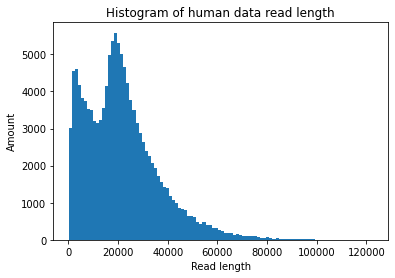

In [7]:
plt.hist(lens, bins = 100)
plt.title("Histogram of human data read length")
plt.xlabel("Read length")
plt.ylabel("Amount")

# Cytosine methylation prediction with neural networks

In [8]:
1+1

2

## Import packages and modules

In [9]:
#dataset and model architectures
from WGBSDataset import WGBSDataset
from NSDataset6 import NSDataset
from TCN_model import TCN_model
from ConvNeXt_model110 import ConvNeXt_model
from Transformer_model_window16 import Transformer_model

#other modules and packages
import os
import numpy as np
import h5py
import math
import torch
import pandas as pd
from torch import split
from time import time
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn import metrics
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pytorch_lightning as pl
import torchmetrics
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import average_precision_score
import random

## Initialization: only has to be done once

### Prepare the WGBS data

In [3]:
#directory to the nanopore sequencing data
NS_dir = '/data/yarivl/H_sapiens/HX1_data/hx1_ab231_2/BNP17L0004-0207-D1_GA30000'

#directories to WGBS coverage files
coverage_dir_1 = '/home/yarivl/WGBS_data_replicate1/SRR8936101.1_1_bismark_bt2_pe.deduplicated.bismark.cov'
coverage_dir_2 = '/home/yarivl/WGBS_data_replicate2/SRR8936102.1_1_bismark_bt2_pe.deduplicated.bismark.cov'

#directories to store processed files
WGBS_dir_1 = '/home/yarivl/thesis/WGBS_data/labels_per_chromosome_1/'
WGBS_dir_2 = '/home/yarivl/thesis/WGBS_data/labels_per_chromosome_2/'
WGBS_dir_merged = '/home/yarivl/thesis/WGBS_data/labels_per_chromosome_merged/'
label_dict_dir = '/home/yarivl/thesis/WGBS_data/npzs/'

In [ ]:
#create directory for storing all necessary files
if not os.path.exists(WGBS_dir_1):
    os.makedirs(WGBS_dir_1)
if not os.path.exists(WGBS_dir_2):
    os.makedirs(WGBS_dir_2)
if not os.path.exists(WGBS_dir_merged):
    os.makedirs(WGBS_dir_merged)
if not os.path.exists(label_dict_dir):
    os.makedirs(label_dict_dir)
    
#choose parameters for dataset creation
min_coverage = 3
interval_size = 1000000

#create a dataset object
WGBS_dataset = WGBSDataset(fast5_dir = NS_dir)
    
#filter WGBS data
WGBS_dataset.filter_WGBS(coverage_dir_1, WGBS_dir_1, min_coverage, upper_cutoff = 90.0, lower_cutoff = 0.0)
WGBS_dataset.filter_WGBS(coverage_dir_2, WGBS_dir_2, min_coverage, upper_cutoff = 90.0, lower_cutoff = 0.0)

#merge WGBS data
WGBS_dataset.merge_WGBS(WGBS_dir_1, WGBS_dir_2, WGBS_dir_merged, min_coverage)

#create label dictionaries
WGBS_dataset.prepare_WGBS(WGBS_dir_merged, label_dict_dir, min_coverage, interval_size)

### Create dataset object

In [ ]:
dataset = NSDataset(fast5_dir = NS_dir, label_dict_dir = label_dict_dir, CpG = True) #17:10 appr 13 min

In [ ]:
torch.save(dataset, 'HX1_train_val_test_split/dataset.pt')

In [14]:
train_inds = []
val_inds = []
test_inds = []
#lens = np.sort(dataset.lengths)

for i in range(int(np.round(len(dataset)/10))):
    #if lens[i] <= 5000:
    rand = random.random()
    if rand < 0.8:
        train_inds.append(i)
    elif rand < 0.9:
        val_inds.append(i)
    else:
        test_inds.append(i)

In [ ]:
np.save('HX1_train_val_test_split/train_inds.npy', train_inds)
np.save('HX1_train_val_test_split/test_inds.npy', test_inds)
np.save('HX1_train_val_test_split/val_inds.npy', val_inds)

# Necessary functions

In [17]:
#collate function for dataloader
def custom_collate(data):
    #unpack data
    X = [seq for seq, target in data]
    Y = [target for seq, target in data]
    
    #pad data
    x = seqs_padded_batched = pad_sequence(X)
    x = torch.transpose(x, dim0 = 1, dim1 = 2)
    x = torch.transpose(x, dim0 = 0, dim1 = 2)
    
    #pad labels
    y = targets_padded_batched = pad_sequence(Y, padding_value = 2.0)
    y = torch.transpose(y, dim0 = 0, dim1 = 1)
    return x, y

## Load data

In [7]:
import torch
model = torch.load("/home/yarivl/thesis/lightning_logs/version_548/checkpoints/epoch=149-step=470399.ckpt")

In [18]:
checkpoint = torch.load("/home/yarivl/thesis/lightning_logs/version_548/checkpoints/epoch=149-step=470399.ckpt")
checkpoint['model_state_dict']

KeyError: 'model_state_dict'

In [24]:
dims = [7, 16, 32, 64, 64]
dropout = 0.2
window = 7
heads = 4
model = Transformer_model(dims, dropout, heads, window)

trainer = pl.Trainer(accelerator = "gpu", devices = "1", max_epochs = 1000, resume_from_checkpoint = '/home/yarivl/thesis/lightning_logs/version_548/checkpoints/epoch=149-step=470399.ckpt')

#model = Transformer_model.from_pretrained("/home/yarivl/thesis/lightning_logs/version_548/checkpoints/epoch=149-step=470399.ckpt")
#checkpoint = torch.load("/home/yarivl/thesis/lightning_logs/version_548/checkpoints/epoch=149-step=470399.ckpt")
#model.load_state_dict(checkpoint['model_state_dict'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [31]:
dataset = torch.load('HX1_train_val_test_split/dataset.pt')

In [32]:
train_inds = np.load('HX1_train_val_test_split/train_inds.npy')
val_inds = np.load('HX1_train_val_test_split/val_inds.npy')
test_inds = np.load('HX1_train_val_test_split/test_inds.npy')

In [33]:
len(test_inds) + len(val_inds) + len(train_inds)

127107

In [34]:
train = Subset(dataset, train_inds)
val = Subset(dataset, val_inds)
test = Subset(dataset, test_inds)

## Train model

In [ ]:
#create dataloaders
train_loader = DataLoader(train, batch_size = 4, num_workers = 16, collate_fn = custom_collate)
val_loader = DataLoader(val, batch_size = 4, num_workers = 16, collate_fn = custom_collate)

#model hyperparameters
dims = [7, 16, 32, 64, 128]
dropout = 0.4
kernel_size = 13

# model
model = ConvNeXt_model(dims, dropout, kernel_size)

# training
trainer = pl.Trainer(accelerator = "gpu", devices = "0", max_epochs = 100)
trainer.fit(model, train_loader, val_loader)

/home/yarivl/anaconda3/envs/thesis/lib/python3.9/site-packages/pytorch_lightning/utilities/device_parser.py:135: LightningDeprecationWarning: Parsing of the Trainer argument gpus='0' (string) will change in the future. In the current version of Lightning, this will select CUDA device with index 0, but from v1.5 it will select gpus [] (same as gpus=0 (int)).
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type       | Params
---------------------------------------
0 | layers  | ModuleList | 190 K 
1 | decoder | Sequential | 129   
---------------------------------------
190 K     Trainable params
0         Non-trainable params
190 K     Total params
0.761     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/yarivl/anaconda3/envs/thesis/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Store model

In [8]:
1+1

2

In [10]:
path = '/home/yarivl/thesis/final_models/ConvNeXt_HX1_2'
torch.save(model, path)

In [11]:
trainer.save_checkpoint('/home/yarivl/thesis/final_models/ConvNeXt_HX1_2.ckpt')

## Resume training if needed

In [10]:
path = "/home/yarivl/thesis/final_models/ConvNeXt_Ecol_1"
model = torch.load(path)

AttributeError: Can't get attribute 'custom_collate' on <module '__main__'>

In [37]:
model.n_params()

[('layers.0.weight', 112),
 ('layers.0.bias', 16),
 ('layers.1.conv.weight', 208),
 ('layers.1.conv.bias', 16),
 ('layers.1.norm.weight', 16),
 ('layers.1.norm.bias', 16),
 ('layers.1.pointwise_net.0.weight', 1024),
 ('layers.1.pointwise_net.0.bias', 64),
 ('layers.1.pointwise_net.3.weight', 1024),
 ('layers.1.pointwise_net.3.bias', 16),
 ('layers.2.weight', 512),
 ('layers.2.bias', 32),
 ('layers.3.conv.weight', 416),
 ('layers.3.conv.bias', 32),
 ('layers.3.norm.weight', 32),
 ('layers.3.norm.bias', 32),
 ('layers.3.pointwise_net.0.weight', 4096),
 ('layers.3.pointwise_net.0.bias', 128),
 ('layers.3.pointwise_net.3.weight', 4096),
 ('layers.3.pointwise_net.3.bias', 32),
 ('layers.4.weight', 2048),
 ('layers.4.bias', 64),
 ('layers.5.conv.weight', 832),
 ('layers.5.conv.bias', 64),
 ('layers.5.norm.weight', 64),
 ('layers.5.norm.bias', 64),
 ('layers.5.pointwise_net.0.weight', 16384),
 ('layers.5.pointwise_net.0.bias', 256),
 ('layers.5.pointwise_net.3.weight', 16384),
 ('layers.5.poi

In [36]:
train_loader = DataLoader(train, batch_size = 4, num_workers = 16, collate_fn = custom_collate)
val_loader = DataLoader(val, batch_size = 4, num_workers = 16, collate_fn = custom_collate)

#model hyperparameters

dims = [7, 16, 32, 64, 128]
dropout = 0.4
kernel_size = 13

#dims = [7, 96, 192, 192, 384, 384]
#dropout = 0.2
#heads = 4
#window = 7
# respectively, a dropout
#of 0.2, 4 attention heads and a window size of 7.

# model
model = ConvNeXt_model(dims, dropout, kernel_size)
trainer = pl.Trainer(accelerator = "gpu", devices = "1", max_epochs = 200, resume_from_checkpoint = '/home/yarivl/thesis/final_models/ConvNeXt_HX1_1.ckpt')

# automatically restores model, epoch, step, LR schedulers, apex, etc...
trainer.fit(model, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Restoring states from the checkpoint file at /home/yarivl/thesis/final_models/ConvNeXt_HX1_1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Restored all states from the checkpoint file at /home/yarivl/thesis/final_models/ConvNeXt_HX1_1.ckpt

  | Name    | Type       | Params
---------------------------------------
0 | layers  | ModuleList | 190 K 
1 | decoder | Sequential | 129   
---------------------------------------
190 K     Trainable params
0         Non-trainable params
190 K     Total params
0.761     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/yarivl/anaconda3/envs/thesis/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f74c2d41160>
Traceback (most recent call last):
  File "/home/yarivl/anaconda3/envs/thesis/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/yarivl/anaconda3/envs/thesis/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/yarivl/anaconda3/envs/thesis/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/yarivl/anaconda3/envs/thesis/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([s

Training: -1it [00:00, ?it/s]

/home/yarivl/anaconda3/envs/thesis/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1051: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Evaluate model

### Calculate precision, recall, false positive rate, true positive rate

In [13]:
del model
torch.cuda.empty_cache()

In [83]:
del test_model
torch.cuda.empty_cache()

NameError: name 'test_model' is not defined

In [25]:
model.eval() #17:33 3 min
y_true = []
y_hat = []

for i in range(len(test)):
    #get predictions
    x = test[i][0]
    x = torch.transpose(x, dim0 = 0, dim1 = 1)
    x = torch.unsqueeze(x, 0)
    y_pred = model(x)
    y_pred = y_pred.detach().numpy()[0]
    
    #get labels
    y_lab = np.array(test[i][1])

    #get mask
    mask = y_lab != 2
    
    y_true.append(y_lab[mask])
    y_hat.append(y_pred[mask])
    
y_true = np.concatenate(y_true)
y_hat = np.concatenate(y_hat)

#calculate precision, recall, false positive rate, true positive rate
fpr, tpr, thresholds_ROC = roc_curve(y_true, y_hat)
precision, recall, thresholds_PR = precision_recall_curve(y_true, y_hat)

#calculate area under the curve
AUC_ROC = metrics.auc(fpr, tpr)
AUC_PR = average_precision_score(y_true, y_hat)
print("AUC_ROC: " + str(AUC_ROC))
print("AUC_PR: " + str(AUC_PR))

y_hat_test = np.copy(y_hat)
y_true_test = np.copy(y_true)

AUC_ROC: 0.5045646247800567
AUC_PR: 0.9385444818044464


In [13]:
AUC_ROC = metrics.auc(fpr, tpr)
AUC_PR = average_precision_score(y_true, y_hat)
print("AUC_ROC: " + str(AUC_ROC))
print("AUC_PR: " + str(AUC_PR))

AUC_ROC: 0.9789308819431108
AUC_PR: 0.9976641097403222


### Plot ROC curve

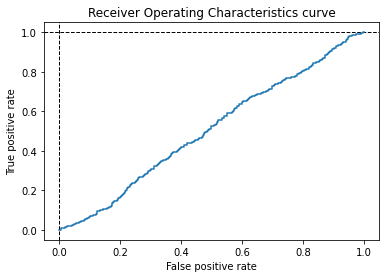

In [26]:
fig, ax = plt.subplots()
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('Receiver Operating Characteristics curve')
ax.axvline(x = 0, color='black', linestyle='--', linewidth = 1)
ax.axhline(y = 1, color='black', linestyle='--', linewidth = 1)
ax.plot(fpr, tpr)

plt.show()

### Plot PR curve

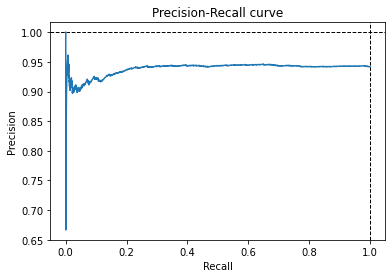

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall curve')
ax.axvline(x = 1, color='black', linestyle='--', linewidth = 1)
ax.axhline(y = 1, color='black', linestyle='--', linewidth = 1)
ax.plot(recall, precision)
#ax.plot(recall[:1935769], thresholds_PR, color = 'orange')

plt.show()

In [18]:
len(precision)

77353

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [29]:
acc = accuracy_score(y_true, np.round(y_hat))
prec = precision_score(y_true, np.round(y_hat))
rec = recall_score(y_true, np.round(y_hat))

In [30]:
print("accuracy: " + str(acc))
print("precision: " + str(prec))
print("recall: " + str(rec))

accuracy: 0.44398340248962653
precision: 0.943762781186094
recall: 0.4356513530522341


In [20]:
test_model.n_params()

[('layers.0.weight', 672),
 ('layers.0.bias', 96),
 ('layers.1.conv.weight', 1248),
 ('layers.1.conv.bias', 96),
 ('layers.1.norm.weight', 96),
 ('layers.1.norm.bias', 96),
 ('layers.1.pointwise_net.0.weight', 36864),
 ('layers.1.pointwise_net.0.bias', 384),
 ('layers.1.pointwise_net.3.weight', 36864),
 ('layers.1.pointwise_net.3.bias', 96),
 ('layers.2.weight', 10752),
 ('layers.2.bias', 112),
 ('layers.3.conv.weight', 1456),
 ('layers.3.conv.bias', 112),
 ('layers.3.norm.weight', 112),
 ('layers.3.norm.bias', 112),
 ('layers.3.pointwise_net.0.weight', 50176),
 ('layers.3.pointwise_net.0.bias', 448),
 ('layers.3.pointwise_net.3.weight', 50176),
 ('layers.3.pointwise_net.3.bias', 112),
 ('decoder.0.weight', 112),
 ('decoder.0.bias', 1),
 ('total', 190193)]

## Get predictions on validation set

In [ ]:
model.eval() #17:33 3 min
y_true = []
y_hat = []

for i in range(len(val)):
    #get predictions
    x = val[i][0]
    x = torch.transpose(x, dim0 = 0, dim1 = 1)
    x = torch.unsqueeze(x, 0)
    y_pred = model(x)
    y_pred = y_pred.detach().numpy()[0]
    
    #get labels
    y_lab = np.array(val[i][1])

    #get mask
    mask = y_lab != 2
    
    y_true.append(y_lab[mask])
    y_hat.append(y_pred[mask])
    
y_true = np.concatenate(y_true)
y_hat = np.concatenate(y_hat)

#calculate precision, recall, false positive rate, true positive rate
fpr, tpr, thresholds_ROC = roc_curve(y_true, y_hat)
precision, recall, thresholds_PR = precision_recall_curve(y_true, y_hat)

#calculate area under the curve
AUC_ROC = metrics.auc(fpr, tpr)
AUC_PR = average_precision_score(y_true, y_hat)
print("AUC_ROC: " + str(AUC_ROC))
print("AUC_PR: " + str(AUC_PR))

y_hat_val = np.copy(y_hat)
y_true_val = np.copy(y_true)

## Store test and validation set predictions

In [ ]:
np.save('/home/yarivl/thesis/results/ConvNeXt/HX1/y_hat_val.npy', y_hat_val)
np.save('/home/yarivl/thesis/results/ConvNeXt/HX1/y_true_val.npy', y_true_val)